## Filtering with SWE --- "immersed bump" example
*Connor Duffin*


In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.insert(0, "../scripts")

from pyDOE import lhs
from scipy.linalg import cho_factor, cho_solve
from statfenics.utils import build_observation_operator
from swe import ShallowOne, ShallowOneLinear
from swe_filter import ShallowOneKalman, ShallowOneEx
from tqdm import tqdm

np.random.seed(28)

In [2]:
def compute_rmse(post, y_obs, H_obs):
    """ Compute the error norm. Computed on a regular grid. """
    y_post = H_obs @ post.mean
    return norm(y_post - y_obs) / norm(y_obs)


def compute_pp(H, swe_post): 
    mean_obs = H @ swe_post.mean 
    HL = H @ swe_post.cov_sqrt
    cov_obs = HL @ HL.T
    cov_obs[np.diag_indices_from(cov_obs)] += sigma_y**2 + 1e-10
    return mean_obs, cov_obs


def compute_coverage(y, mean , cov):
    lower = mean - 1.96 * np.sqrt(cov.diagonal())
    upper = mean + 1.96 * np.sqrt(cov.diagonal())
    return ((y > lower) & (y < upper)).sum() / nx_obs

In [3]:
norm = np.linalg.norm

NX = 1000
DT = 0.01
THETA = 0.6
NU = 1e-6

# set the observation system
t_final = 200.
nt = np.int64(t_final / DT)
t_grid = np.arange(0., t_final, DT)

k = 32
nt_skip = 100
sigma_y = 5e-4

In [4]:
stat_params = dict(rho_u=1e-2, ell_u=5.,
                   rho_h=1, ell_h=5.,
                   k=k, k_init_u=k, k_init_h=k,
                   hilbert_gp=True)

swe_prior = ShallowOneEx(
    control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
    params=dict(nu=NU, bump_centre=10),
    stat_params=stat_params,
    lr=True)

swe_post = ShallowOneKalman(
    control=dict(nx=NX, dt=DT, theta=THETA),
    params=dict(nu=0., bump_centre=10),
    stat_params=stat_params,
    lr=True)

swe_post_ex = ShallowOneEx(
    control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
    params=dict(nu=NU, bump_centre=10),
    stat_params=stat_params,
    lr=True)

# build obs. operator
nt_obs = len([i for i in range(nt) if i % nt_skip == 0])
H_u_verts = build_observation_operator(swe_post.x_coords, swe_post.W, sub=0)
H_h_verts = build_observation_operator(swe_post.x_coords, swe_post.W, sub=1)

print(f"Assimilating every {nt_skip} timesteps ({nt_skip * swe_post.dt:.3f} s)")
print(f"Observational noise has std. dev. {sigma_y:.4e}")

Assimilating every 100 timesteps (1.000 s)
Observational noise has std. dev. 5.0000e-04


In [23]:
nx_skip = 10
dat = xr.open_dataset("../data/h_bump.nc")

# do some double checking
assert DT == dat.coords["t"].values[1] - dat.coords["t"].values[0]
# np.testing.assert_allclose(dat.coords["x"].values, swe_post.x_coords.flatten())

# build observation/interpolation operators
y_obs = dat["h"].values[1:, ::nx_skip]  # dont include IC
print(y_obs.shape)
x_obs = dat.coords["x"].values[::nx_skip][:, np.newaxis]
nx_obs = len(x_obs)
H_obs = build_observation_operator(x_obs, swe_post.W, sub=1, out="scipy")
H_u_verts = build_observation_operator(swe_post.x_coords, swe_post.W, sub=0)
H_h_verts = build_observation_operator(swe_post.x_coords, swe_post.W, sub=1)

(30000, 51)


In [6]:
errors_u = np.zeros((nt, ))
errors_h = np.zeros((nt, ))

errors_u_ex = np.zeros((nt, ))
errors_h_ex = np.zeros((nt, ))

coverage = np.zeros((nt_obs, ))
means_obs = np.zeros((nt_obs, nx_obs))
covs_obs = np.zeros((nt_obs, nx_obs, nx_obs))

rmse = np.zeros((nt_obs, ))
rmse_ex = np.zeros((nt_obs, ))
rmse_prior_ex = np.zeros((nt_obs, ))

lml = np.zeros((nt_obs, ))
lml_ex = np.zeros((nt_obs, ))

t = 0.
i_save = 0
n_plot = int(3 * nt // 4)
for i in tqdm(range(nt)):
    t += swe_post.dt

    swe_prior.prediction_step(t)
    swe_post.prediction_step(t)
    swe_post_ex.prediction_step(t)
    
    if i % nt_skip == 0:
        lml[i_save] = swe_post.compute_lml(y_obs[i, :], H_obs, sigma_y)
        lml_ex[i_save] = swe_post_ex.compute_lml(y_obs[i, :], H_obs, sigma_y)

        swe_post.update_step(y_obs[i, :], H_obs, sigma_y)
        swe_post_ex.update_step(y_obs[i, :], H_obs, sigma_y)
        
        rmse[i_save] = compute_rmse(swe_post, y_obs[i, :], H_obs)
        rmse_ex[i_save] = compute_rmse(swe_post_ex, y_obs[i, :], H_obs)
        rmse_prior_ex[i_save] = compute_rmse(swe_prior, y_obs[i, :], H_obs)
        
        means_obs[i_save, :], covs_obs[i_save, :, :] = compute_pp(H_obs, swe_post)
        coverage[i_save] = compute_coverage(y_obs[i, :],
                                            means_obs[i_save, :],
                                            covs_obs[i_save, :, :])
        i_save += 1
        
    if i % n_plot == 0:
        # data
        y_plot = y_obs[i, :]

        # prior
        u_prior, h_prior = swe_prior.get_vertex_values()
        var_u_prior = np.diagonal(H_u_verts @ swe_prior.cov_sqrt @ (H_u_verts @ swe_prior.cov_sqrt).T)
        var_h_prior = np.diagonal(H_h_verts @ swe_prior.cov_sqrt @ (H_h_verts @ swe_prior.cov_sqrt).T)

        # linear
        u_mean, h_mean = swe_post.get_vertex_values()
        var_u = np.diagonal(H_u_verts @ swe_post.cov_sqrt @ (H_u_verts @ swe_post.cov_sqrt).T)
        var_h = np.diagonal(H_h_verts @ swe_post.cov_sqrt @ (H_h_verts @ swe_post.cov_sqrt).T)

        # nonlinear
        u_mean_ex, h_mean_ex = swe_post_ex.get_vertex_values()
        var_u_ex = np.sum((H_u_verts @ swe_post_ex.cov_sqrt)**2, axis=1)
        var_h_ex = np.sum((H_h_verts @ swe_post_ex.cov_sqrt)**2, axis=1)
        
    swe_prior.set_prev()
    swe_post.set_prev()
    swe_post_ex.set_prev()

100%|███████████████████████████████████████████████████████████████████| 20000/20000 [15:04<00:00, 22.12it/s]


In [7]:
print(f'{np.sum(lml):.4e}', f'{np.sum(lml_ex):.4e}')

-2.0618e+10 -1.8191e+10


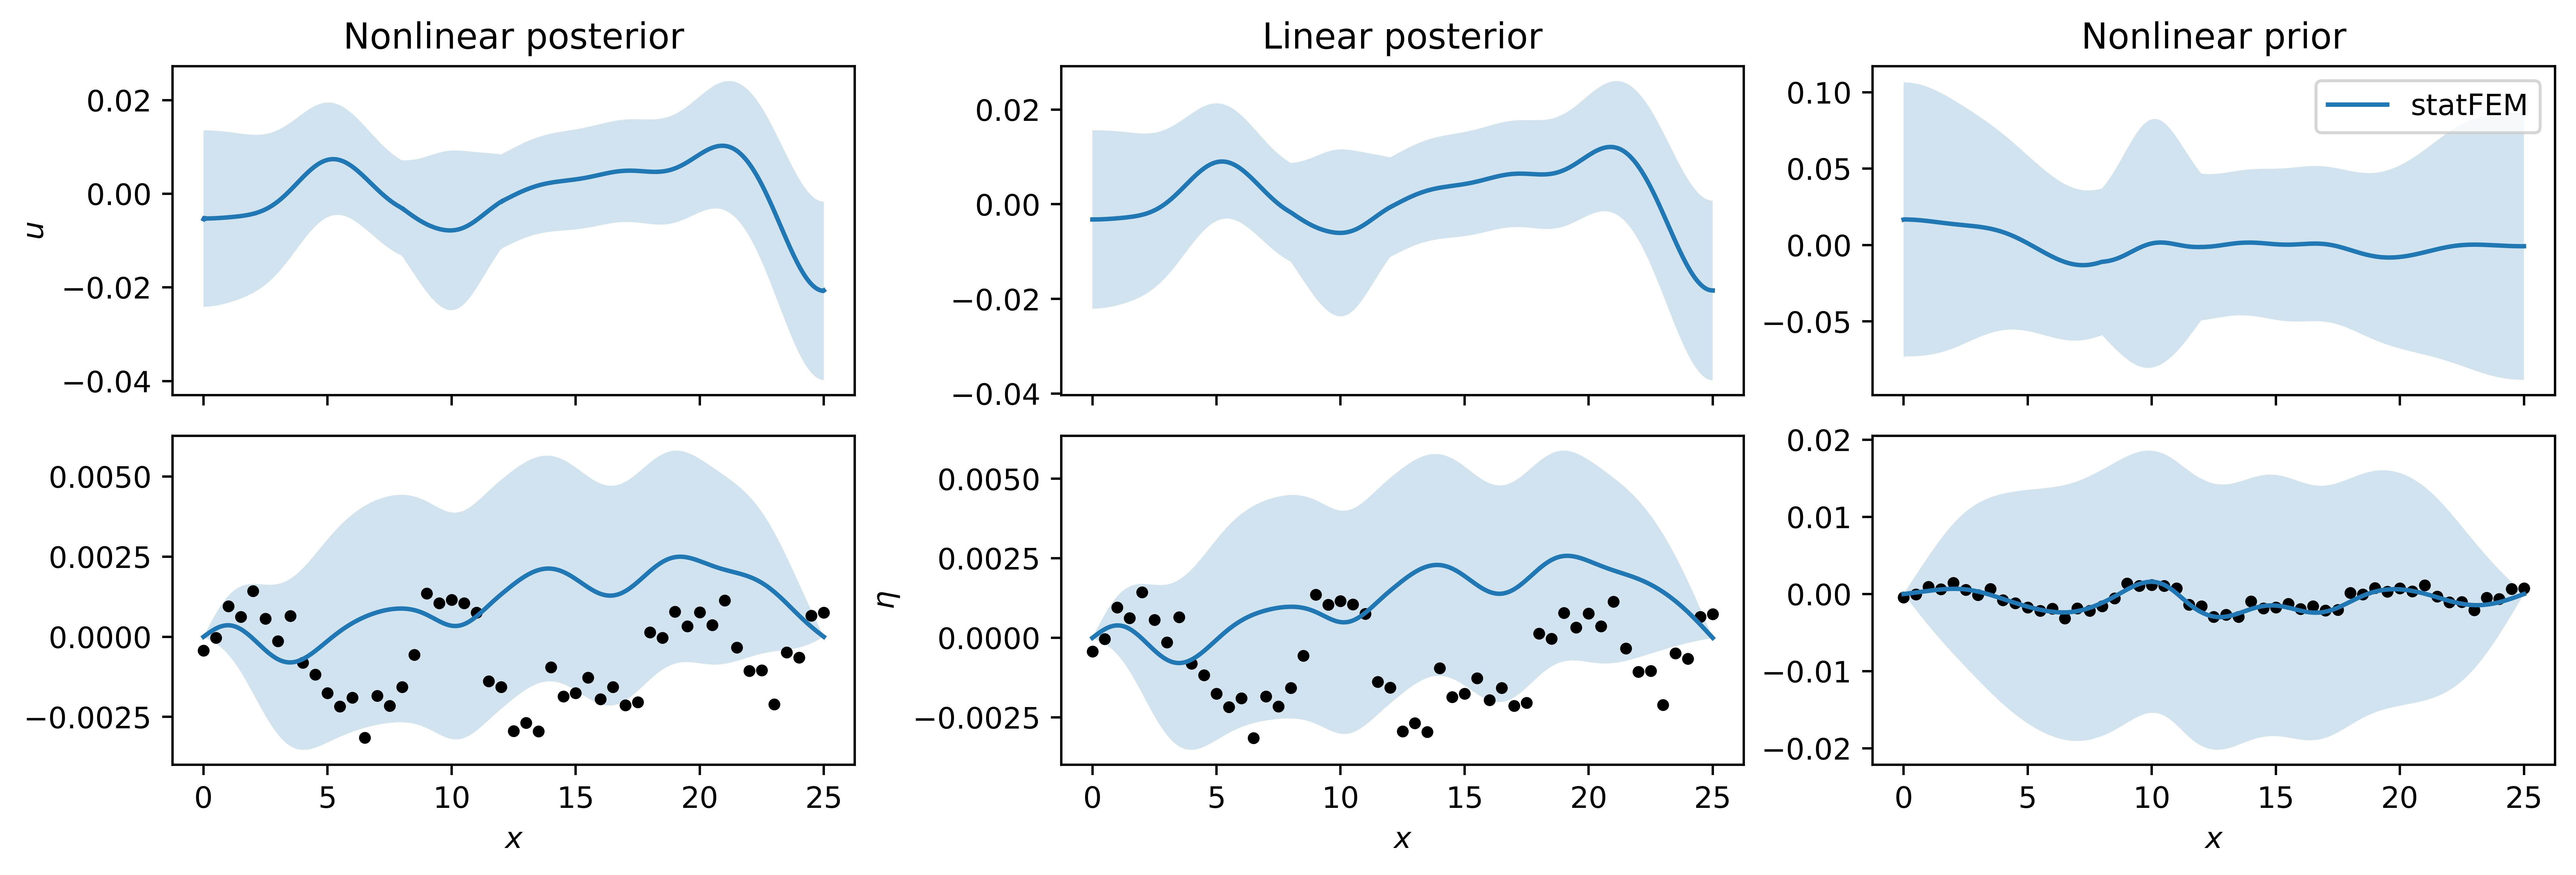

In [19]:
fig, axs = plt.subplots(2, 3, 
                        constrained_layout=True, 
                        figsize=(12, 4), 
                        sharey=False, 
                        sharex=True,
                        dpi=700)
axs = axs.flatten()

# velocities
x_grid = swe_post.x_coords
axs[0].plot(x_grid, u_mean_ex)
axs[0].fill_between(x_grid[:, 0], 
                    u_mean_ex - 1.96 * np.sqrt(var_u_ex), u_mean_ex + 1.96 * np.sqrt(var_u_ex),
                    alpha=0.2)
axs[0].set_ylabel(r"$u$")
axs[0].set_title(r"Nonlinear posterior")

axs[1].plot(x_grid, u_mean)
axs[1].fill_between(x_grid[:, 0], 
                    u_mean - 1.96 * np.sqrt(var_u), u_mean + 1.96 * np.sqrt(var_u),
                    alpha=0.2)
axs[1].set_title(r"Linear posterior")

axs[2].plot(x_grid, u_prior, label="statFEM")
axs[2].fill_between(x_grid[:, 0], 
                    u_prior - 1.96 * np.sqrt(var_u_prior), 
                    u_prior + 1.96 * np.sqrt(var_u_prior),
                    alpha=0.2)
axs[2].legend()
axs[2].set_title(r"Nonlinear prior")

# surface heights
axs[3].plot(x_obs, y_plot, ".", color="black")
axs[3].plot(x_grid, h_mean_ex, label="Posterior")
axs[3].fill_between(x_grid[:, 0], 
                    h_mean_ex - 1.96 * np.sqrt(var_h_ex), h_mean_ex + 1.96 * np.sqrt(var_h_ex),
                    alpha=0.2)
axs[3].set_xlabel(r"$x$")

axs[4].plot(x_obs, y_plot, ".", color="black")
axs[4].plot(x_grid, h_mean, label="Posterior")
axs[4].fill_between(x_grid[:, 0], 
                    h_mean - 1.96 * np.sqrt(var_h), h_mean + 1.96 * np.sqrt(var_h),
                    alpha=0.2)
axs[4].set_ylabel(r"$\eta$")
axs[4].set_xlabel(r"$x$")

axs[5].plot(x_obs, y_plot, ".", color="black")
axs[5].plot(x_grid, h_prior)
axs[5].fill_between(x_grid[:, 0],
                    h_prior - 1.96 * np.sqrt(var_h_prior), h_prior + 1.96 * np.sqrt(var_h_prior),
                    alpha=0.2)
axs[5].set_xlabel(r"$x$")
plt.show()

Now we check, in the meantime, to make sure that a quicker variance calculation works out OK:

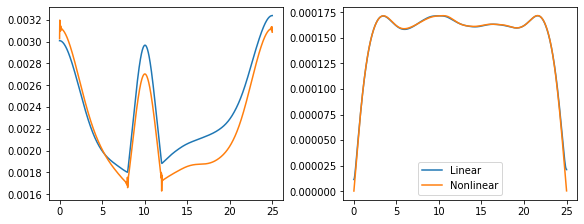

In [9]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3))
axs[0].plot(swe_post.x_coords, np.sqrt(var_u))
axs[0].plot(swe_post.x_coords, np.sqrt(var_u_ex))
axs[1].plot(swe_post.x_coords, np.sqrt(var_h), label="Linear")
axs[1].plot(swe_post.x_coords, np.sqrt(var_h_ex), label="Nonlinear")
axs[1].legend()
plt.show()

Next we plot the relative errors and we see that they look OK:

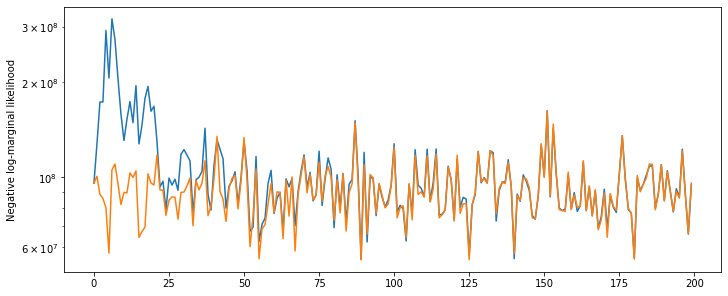

In [10]:
fig, ax = plt.subplots(1, 1,  constrained_layout=True, figsize=(10, 4))
ax.semilogy(-lml)
ax.semilogy(-lml_ex)
ax.set_ylabel("Negative log-marginal likelihood")
plt.show()

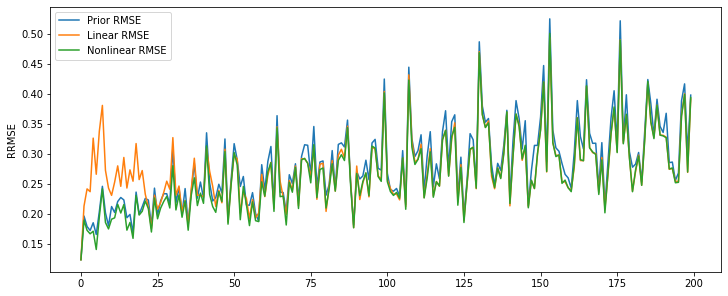

In [11]:
fig, ax = plt.subplots(1, 1,  constrained_layout=True, figsize=(10, 4))
ax.plot(rmse_prior_ex, label="Prior RMSE")
ax.plot(rmse, label="Linear RMSE")
ax.plot(rmse_ex, label="Nonlinear RMSE")
ax.set_ylabel("RRMSE")
plt.legend()
plt.show()

In [12]:
print(np.sum(rmse) / len(rmse), 
      np.sum(rmse_ex) / len(rmse_ex), 
      np.sum(rmse_prior_ex) / len(rmse_prior_ex))

0.27774689592092067 0.26641699968935023 0.28210738587547673


Next, we look at the prediction means and variances

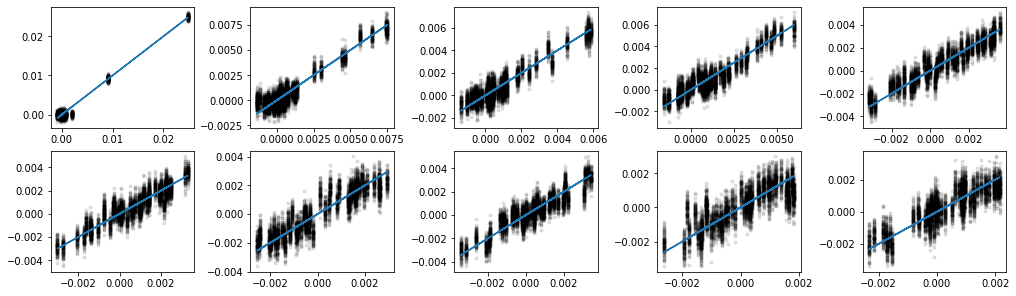

In [13]:
time_indices = np.int64(np.linspace(0, nt_obs - 1, 10))
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(14, 4))
axs = axs.flatten()
for i, idx in enumerate(time_indices):
    mean = means_obs[idx, :]
    cov = covs_obs[idx, :]
    y = y_obs[nt_skip * idx, :]
    samples = np.random.multivariate_normal(mean=mean, cov=cov, size=100)
    
    axs[i].plot(y, samples.T, ".", alpha=0.1, color="black")
    axs[i].plot(y, y)
    

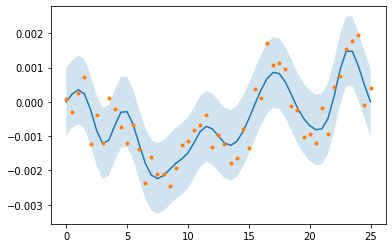

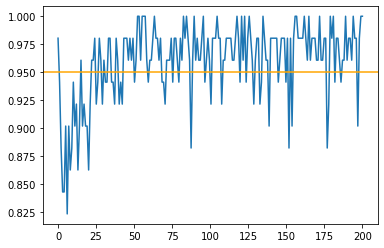

In [21]:
for i in range(nt_obs // 2):
    mean = means_obs[i, :]
    cov = covs_obs[i, :]
    y = y_obs[nt_skip * i, :]
    
    lower = mean - 1.96 * np.sqrt(cov.diagonal())
    upper = mean + 1.96 * np.sqrt(cov.diagonal())

plt.plot(x_obs, mean)
plt.fill_between(x_obs[:, 0], lower, upper, alpha=0.2)
plt.plot(x_obs, y, ".")
plt.show()

plt.plot(np.linspace(0, t_final, len(coverage)), coverage)
plt.axhline(y=0.95, color="orange")
plt.show()

0.9597058823529412 0.9607843137254902


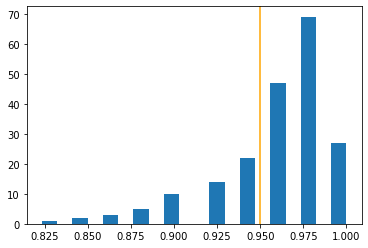

In [15]:
print(np.mean(coverage), np.median(coverage))
plt.hist(coverage, bins=20)
plt.axvline(x=0.95, color="orange")
plt.show()

In [16]:
for i in tqdm(range(int(5. / DT))):  # forecast forward 5s
    t += swe_post.dt
    swe_post_ex.prediction_step(t)
    swe_post_ex.set_prev()
    
    swe_post.prediction_step(t)
    swe_post.set_prev()

100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 36.29it/s]
